# Capstone Final Assignment
## Exploring venues for visitors in Ottawa, ON, Canada

## Table of Contents

* [Introduction](#introduction)
* [Data Collection](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

This project focuses on exploring venues that best suit for visitors in Ottawa (ON, Canada). When visitors plan to travel to a city, they will be looking for places to stay, to visit, to eat and drink... They primarily aim to places having good ratings across all venues and the average prices that fit their budget. Therefore, we will especially focus on the ratings and average prices of the venues.

We will need the support of two api providers: **Foursquare API** and **Zomato API**. The former is to determine the locations of interest while the latter provides their rating and price information. This work helps to **identify places that are fit for different visitors**. Once we finish exploring these venues, any company can launch an application and provide suggestions for users.

## Data Collection <a name="data_collection"></a>

We will fetch the data using the two different APIs as follow:
* **Foursquare API** fetches venues in Ottawa in the radius of 4 kilometers from the city center.
* **Zomato API** provides information related to the venues within this area, e.g. the complete address, user ratings, price range, and so on.

The data will be represented as tabular form.

### Ottawa

Ottawa is the capital of Canada with the area about 2,790 km2. There are many venues for visitors such as restaurants, hotels and coffee shops.

Since the geocode of this city can be easily determined, we simply assign its latitude and longitude values as constant in this notebook.

In [2]:
LATITUDE = 45.421530
LONGITUDE = -75.697193

We will use the `folium` library to visualize the map of interest. 

In [ ]:
!pip install folium

In [4]:
import folium

target_location_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)
folium.Marker([LATITUDE, LONGITUDE]).add_to(target_location_map)
target_location_map

### Foursquare API

Now we will determine venues in Ottawa up to a radius of 4 kilometers from the city center using the Foursquare API. We consider only 4 kilometers because of the quota of number of calling given by Foursquare. 

We will use the `explore` API to find all the venues within the area.

In [5]:
# The code was removed by Watson Studio for sharing.

In [7]:
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100 # Venues to obtain for each calling
VERSION = '20201014' # Current date

We define the `get_category` method to that extracts the category of each venue.

In [8]:
def get_category(item):
    try:
        categories_list = item['categories']
    except:
        categories_list = item['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

We iteratively call the API until obtaining all the venues within the given radius. Each time we call, the API will provide up to 100 venues.

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    uri = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        LATITUDE, 
                                                                        LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(uri).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched

    venues = result['response']['groups'][0]['items']
    venues = pd.json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < NO_OF_VENUES):
        break
    else:
        offset += NO_OF_VENUES

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal fetched venues: {}".format(total_venues))

foursquare_venues.head()


Total fetched venues: 83


,name,categories,lat,lng
0,National Arts Centre - Centre National des Arts,Concert Hall,45.422922,-75.692996
1,Sansotei Ramen 三草亭,Noodle House,45.418920,-75.699328
2,National War Memorial,Memorial Site,45.423909,-75.695221
3,Rideau Canal,Other Great Outdoors,45.424781,-75.695129
4,Alt Hotel Ottawa,Hotel,45.419973,-75.698948


### Zomato API

The Zomato API can search for a venue given certain search filters such as query, latitude, or longitude.

The search API will be performed according to the `name`, `lat`, and `lng` values of the fetched venues.

In the URI, we will provide
* The name of the venue
* The start offset, we set to 0 by default
* The number of venues we want to fetch. Since we provide the exact location, we will fetch only one.
* The latitude and longitude values.
* The results will be sorted by `real_distance` to guarantee that we will get the venue at the provided location.

In [10]:
# The code was removed by Watson Studio for sharing.

In [11]:
venues_information = []

for index, row in foursquare_venues.iterrows():
    venue = []
    uri = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try:
        result = requests.get(uri, headers = headers).json()
    except:
        print("There was an error for fetching {}".format(row['name']))
    try:
        
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(6))
    except:
        pass
        
zomato_venues = pd.DataFrame(venues_information, columns = ['venue', 'latitude', 'longitude', 'price_for_two', 'price_range', 'rating', 'address'])
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Le Café,45.4232850000,-75.6946990000,115.0,4.0,3.4,"National Arts Centre, 53 Elgin Street, Ottawa ..."
1,Sansotei Ramen,45.4189760000,-75.6991850000,0.0,1.0,3.8,"153 Bank Street, Ottawa K1P 5N7"
2,Le Café,45.4232850000,-75.6946990000,115.0,4.0,3.4,"National Arts Centre, 53 Elgin Street, Ottawa ..."
3,Wilfrid's Restaurant - Fairmont Château Laurier,45.4251800000,-75.6944100000,120.0,4.0,3.5,"Fairmont Château Laurier, 1 Rideau Street, Ott..."
4,Juice Monkey,45.4198833333,-75.6996166667,25.0,2.0,3.5,"209 Slater Street, Ottawa K1P 5N5"


## Data Cleaning <a name="data_cleaning"></a>

Since the current data is collected from different sources, we need to combine them and then perform data cleansing.

#### Merging data from the two dataframes

For each venue, we have two data points where each one belongs to the results provided by one of the two APIs. We thus need to find a way combining them properly.

It is typical to guess that there may be a small coordinate variation (i.e. distance) between the two points (of the two dataframes) indicating the same venue.

First, such variation may come from the problem of number representation on computer. Therefore, we should try to round the coordinate values with a smaller number of decimal places. Concretely, the latitude and longitude will be rounded to have 4 decimal places. Venues of small location variation are now matched between the two dataframes.

In [59]:
# Foursquare dataframe
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
foursquare_venues.head()

,name,categories,lat,lng
0,National Arts Centre - Centre National des Arts,Concert Hall,45.4229,-75.6930
1,Sansotei Ramen 三草亭,Noodle House,45.4189,-75.6993
2,National War Memorial,Memorial Site,45.4239,-75.6952
3,Rideau Canal,Other Great Outdoors,45.4248,-75.6951
4,Alt Hotel Ottawa,Hotel,45.4200,-75.6989


In [60]:
# Zomato dataframe
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Le Café,45.4233,-75.6947,115.0,4.0,3.4,"National Arts Centre, 53 Elgin Street, Ottawa ..."
1,Sansotei Ramen,45.4190,-75.6992,0.0,1.0,3.8,"153 Bank Street, Ottawa K1P 5N7"
2,Le Café,45.4233,-75.6947,115.0,4.0,3.4,"National Arts Centre, 53 Elgin Street, Ottawa ..."
3,Wilfrid's Restaurant - Fairmont Château Laurier,45.4252,-75.6944,120.0,4.0,3.5,"Fairmont Château Laurier, 1 Rideau Street, Ott..."
4,Juice Monkey,45.4199,-75.6996,25.0,2.0,3.5,"209 Slater Street, Ottawa K1P 5N5"


There is also a possible risk that the two obtained coordinates for a venue has a significant distance, i.e. they are still not the same after rounding. In this case, we can use a distance threshold to determine whether they indicate the same venue or not. We will set the threshold as 0.0004 for both latitude and longitude displacements.

In [61]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

thresh = 0.0004
confident_venues = dataset[(abs(dataset['lat_diff']) <= thresh) & (abs(dataset['lng_diff']) <= thresh)].reset_index(drop = True)

In [62]:
print(confident_venues.shape)
confident_venues.head()

(55, 13)


,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sansotei Ramen 三草亭,Noodle House,45.4189,-75.6993,Sansotei Ramen,45.4190,-75.6992,0.0,1.0,3.8,"153 Bank Street, Ottawa K1P 5N7",0.0001,0.0001
1,Riviera,Modern European Restaurant,45.4232,-75.6962,Riviera,45.4234,-75.6963,25.0,2.0,3.8,"62 Sparks Street, Ottawa K1P 5A5",0.0002,-0.0001
2,Confederation Park,Park,45.4221,-75.6925,Royi Fruta Bar,45.4222,-75.6924,10.0,1.0,0,"Confederation Park, Ottawa K1P 5J2",0.0001,0.0001
3,North & Navy,Italian Restaurant,45.4167,-75.6990,North & Navy,45.4168,-75.6991,90.0,4.0,4.1,"226 Nepean Street, Ottawa K2P 0B8",0.0001,-0.0001
4,La Bottega,Deli / Bodega,45.4269,-75.6919,La Bottega Nicastro,45.4270,-75.6921,20.0,2.0,4.6,"64 George Street, Ottawa K1N 5V9",0.0001,-0.0002


It is noticeable that some venues have the mismatched names in the two sources, e.g. Confederation Park and Royi Fruta Bar at index=2.

There are different possible reasons such as: **(1)** they are 2 different venues located in the same building, or **(2)** they are two close and their coordinates are thus quite similar, or **(3)** an old venue was replaced by the other one (due to the different updated dates of the two APIs). In the example of index=2, it seems the third reason since the corresponding rating is 0 (i.e. it is a new venue).

They may be fixed in various ways such as waiting for the updated API version, manual tuning the information, or simply skip them (since users normally focus more on the venue category than its name).

#### Normalizing and removing unnecessary information

We will normalize the price by dividing the values in column `price_for_two` by 2.

In [63]:
confident_venues['average_price'] = confident_venues['price_for_two']/2.0

 We will work on the venue name from **Zomato API**. We will then remove unnecessary columns

In [64]:
confident_venues = confident_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

For the venues that do not have rating, we should remove them since the visitors will not expect going there.

In [65]:
final_venues = confident_venues[confident_venues['rating'] != 0.0].reset_index(drop=True)

This is the final dataset for our further exploration

In [66]:
print(final_venues.shape)
final_venues.head(5)

(51, 8)


,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Noodle House,Sansotei Ramen,45.4190,-75.6992,1.0,3.8,"153 Bank Street, Ottawa K1P 5N7",0.0
1,Modern European Restaurant,Riviera,45.4234,-75.6963,2.0,3.8,"62 Sparks Street, Ottawa K1P 5A5",12.5
2,Italian Restaurant,North & Navy,45.4168,-75.6991,4.0,4.1,"226 Nepean Street, Ottawa K2P 0B8",45.0
3,Deli / Bodega,La Bottega Nicastro,45.4270,-75.6921,2.0,4.6,"64 George Street, Ottawa K1N 5V9",10.0
4,Market,Maple Valley Tea World,45.4276,-75.6925,1.0,3.5,"55 ByWard Market Square, Ottawa K1N 9C3",5.0


## Methodology <a name="methodology"></a>

We will perform analysis on the data based on the ratings and the average price of each venue.

We will **determine venue categories** that are majority in the area of interest. According to that information, the visitors can expect these activities when going there.

We will also explore areas of **high ratings** and those of **low rating** using visualization. The results will be useful for users since they tend to visit high rated places and avoid low rated ones.

Finally, we will discuss and conclude which venues to be explored based on **visitor requirement of rating and cost**.

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 36 artists>

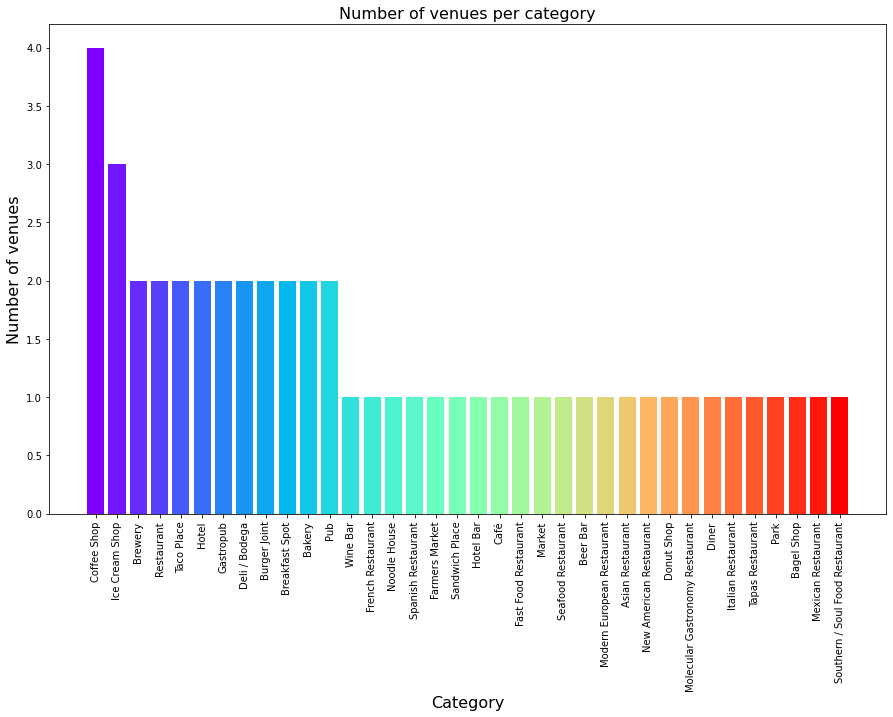

In [67]:
venue_distribution = final_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (15, 9))
plt.xticks(rotation = 90)
plt.xlabel("Category", fontsize = 16)
plt.ylabel("Number of venues", fontsize = 16)
plt.title("Number of venues per category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

It is obvious that the two majority venues are **coffee shop** and **ice cream shop**. Therefore, there is the good place for visitors who want to relax with a cup of coffee or enjoy ice cream.

### Rating

Venue's rating is an important factor for a visitor to decide whether it is worth it to visit the place. We will take a look on the overall statistic of rating.

Text(0.5, 1.0, 'Number of venues with given rating')

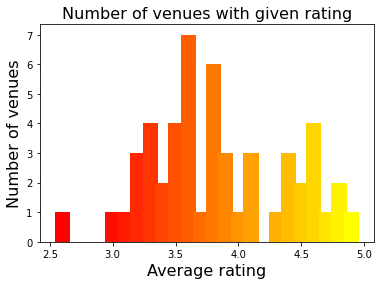

In [68]:
final_venues['rating'] = final_venues['rating'].astype(float)
rating = final_venues['rating'].value_counts().sort_index()

plt.bar(rating.index, rating.values, width=0.12, color=cm.autumn(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Average rating", fontsize = 16)
plt.ylabel("Number of venues", fontsize = 16)
plt.title("Number of venues with given rating", fontsize = 16)

The plot above shows that most venues have **the rating of 3.6**, and the distribution tends to skew to the higher rating direction. There are also many venues of high ratings from **4.3 to 4.9**.

Now we create bins for ratings and plot them in different colors on the map. The ratings will be divided between 4 bins corresponding to the qualities *Very good*, *Good*, *Average*, and *Low*:
* 1 to 2: Low
* 2 to 3: Average
* 3 to 4: Good
* 4 to 5: Very good

In [69]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
final_venues['rating_bin'] = pd.cut(final_venues['rating'].astype(float), bins=bins, labels=labels, include_lowest=True)

We will plot the venues on the map to have a visual overview

In [70]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'darkgreen', 'Very good': 'green'}

target_location_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)

for item in zip(final_venues['venue'], final_venues['address'], final_venues['latitude'], final_venues['longitude'], final_venues['rating_bin']):
    name, address, latitude, longitude, rating_bin = item
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(target_location_map)  

target_location_map

According to the markers shown on the map, the venues located near an end of the **Pont Alexandra bridge** tend to have good and very good ratings (3.0 to 5.0) and they are close to each other. It is a good idea for visitors to check out that area. The areas **Centertown** and **Hintonburg** are also worth to visit though they have less venues compared to the first area.

### Price

We will now take a look on the average price per person. There are two price features including `average_price` which indicates the average cost for one person and `price_range` which determines the price range as defined by Zomato.

We will first explore the `average_price` using a scatter plot between the average price and the number of venues. The point size indicates the corresponding price.

Text(0.5, 1.0, 'Number of venues with given average price')

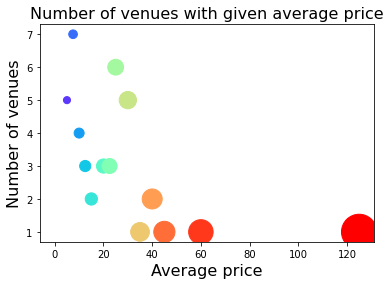

In [71]:
average_prices = final_venues['average_price'].value_counts().sort_index()

plt.scatter(average_prices.index, average_prices.values, s = average_prices.index*10, c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Average price", fontsize = 16)
plt.ylabel("Number of venues", fontsize = 16)
plt.title("Number of venues with given average price", fontsize = 16)

The plot shows that **most venues have low price (less than 40)**. Therefore, this area of Ottawa is suitable for visitors who want to travel without spending much for their budget.

In some cases, users focus on the overall price of an area where they plan to spend their money for various activities that fit their budget. We will use the `price_range` information to plot the venues on a map. The color will change from green to red as the increasing of price.

In [72]:
color_map = {1: 'green', 2: 'darkgreen', 3: 'orange', 4: 'red'}

target_location_map = folium.Map(location = [LATITUDE, LONGITUDE], zoom_start = 13)

for item in zip(final_venues['venue'], final_venues['address'], final_venues['latitude'], final_venues['longitude'], final_venues['price_range']):
    name, address, latitude, longitude, price_range = item
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(target_location_map)  

target_location_map

Once again, we see that the venues located near **an end of the Pont Alexandra bridge** and the **Centertown** areas are suitable for visitors who want to save their pocket. The visitors who want to spend their money a lot can go to nearby areas, including the other end of the bridge.

## Results and Discussion <a name="results"></a>

According to the analysis above, we obtain a number of conclusions that will be useful to aid visitors at Ottawa, ON, Canada.

First, some mismatches of venue names in the data obtained from Foursquare and Zomato indicate that some venues may be recently replaced by new ones. Therefore, the visitors should check carefully their objective places (via website, other search engines...) before coming there.

The two majority venues in the studied area of Ottawa are coffee shop and ice cream shop. Therefore, that is the good place for visitors who want to relax with a cup of coffee or enjoy ice cream.

Most venues have the rating of 3.6 and there are also many venues of high ratings from 4.3 to 4.9. The visitors thus can satisfy with the services they will use there.

In more details, the venues located near an end of the Pont Alexandra bridge tend to have good and very good ratings (3.0 to 5.0) and they are close to each other. It is a good idea for visitors to check out that area. The areas Centertown and Hintonburg are also worth to visit though they have less venues compared to the first area.

Besides, most venues have low price (less than 40). Therefore, this area of Ottawa is suitable for visitors who want to travel without spending much for their budget. In addition, the venues located near an end of the Pont Alexandra bridge and the Centertown areas are suitable for visitors who want to save their pocket. The visitors who want to spend their money a lot can go to nearby areas, including the other end of the bridge.

A company can use the above information to build up an online website/application, to provide users with up to date information about various venues in Ottawa based on the search criteria (name, rating and price).

## Conclusion <a name="conclusion"></a>

The objective of this project is to explore the venues that visitors at Ottawa, ON, Canada should visit. The primary criteria are venue rating and price related information. The venues have been identified using Foursquare and Zomato APIs and have been plotted on the map. The exploration can be adapted to other cities and for other criteria.